# CS 480/680 assignment 3

Tips:
- Please save a copy of this notebook to avoid losing your changes.
- Debug your code and ensure that it can run.
- Save the output of each cell. Failure to do so may result in your coding questions not being graded.
- To accelerate the training time, you can choose 'Runtime' -> 'Change runtime type' -> 'Hardware accelerator' and set 'Hardware accelerator' to 'GPU'.
- Your grade is independent of the accuracy of your models. Your grade will depend on the correctness of your code and implementation.

Tips for sumbission:
- Do not change the order of the problems.
- Select 'Runtime' -> 'Run all' to run all cells and generate a final "gradable" version of your notebook and save your ipynb file.
- Also use 'File' -> 'Print' and then print your report from your browser into a PDF file.

## Question 1 - Implementing GAN for MNIST dataset (35 points)

In this question we are going to impelement a generative network that can generate MNIST handwritten digits from random Gaussian noise.

### Q1.1 (2 points)

We start by creating the data loaders. Note that each MNIST image is of size 28\*28. The **first task** is to build the ```data_loader```

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os


# Setting the device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 100
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

#ToDo: Build the train data loader using the above batch_size varibale and shuffling the dataset.
data_loader = DataLoader(dataset=train_dataset, 
                          batch_size=100, 
                          shuffle=True)



Using device: mps


### Q1.2 Generator (5 points)
We will be building simple Generator and Discriminators that only consist of fully-connected layers. The Generator takes as input a Gaussian vector with dimension ```n_dim```. It consists of two linear layers with ```256``` and ```512``` nodes and the output layer should of dimension ```28*28=784``` so that it can be considered as unfolding a ```28*28``` image into a vector. The **second task** is to complete the following code for building the Generator.

In [3]:
class Generator(nn.Module):
    def __init__(self, n_dim):
        super(Generator, self).__init__()
        #ToDo: Complete the code
        #The activation function for the two hidden layers is ReLU.
        #The last layer's activation function is Tanh.
        
        self.fc1 = nn.Linear(n_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 28*28)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()


    def forward(self, x):
        #ToDo: Complete this function. The function takes as input x and outputs the result of applying the generator on x.
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x


### Q1.3 Discriminator (5 points)
The Discriminator takes as input an image of size ```28*28```. It consists of two linear layers with ```512``` and ```256``` nodes and the output layer should be a single node. The **third task** complete the following code for building the Discriminator.

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
            #ToDo: Complete the code
            #The activation functions for the two hidden layers are ReLU.
            #The last layer's activation function is Sigmoid.
        self.fc1 = nn.Linear(28*28,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1) # Making sure that the batch of images has the shape [batch_size,28*28] instead of [batch_size,1,28,28]
        #ToDo: Complete this function. The function takes as input x and outputs the result of applying the generator on x.
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x)) 
        return x

### Q1.4 Initializaiton (2 points)

The **fourth task** is to define the optimizers.

In [6]:
n_dim = 100
generator = Generator(n_dim).to(device)
discriminator = Discriminator().to(device)
lr = 0.0002


criterion = nn.BCELoss()
#ToDo: define the two different Adam optimizers for generator and discriminator with learning rates of lr.

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

### Q1.5 Training (16 points)

Note that when applying the ```criterion``` both the inputs should be on the same device. If you are defining a set of labels that you want to use in ```criterion``` you must move them to ```device``` first.

Recall from the Goodfellow et al. 2014 that the following happens during the minimax game between Discriminator and the Generator.

Discriminator is ascending
$\nabla\frac{1}{m}\sum_{i=1}^m\log D(x^{(i)}) + \log(1-D(G(z^{(i)})))$ where $D$ and $G$ denote the Districiminator and the Generator, respectively. Here, $x^{1},\ldots,x^{m}$ is the batch of training examples (i.e., MNIST images) and $z^{(1)},\ldots,z^{(m)}$ is a batch of random noise.

Also note that for two batches $x=\{x^{1},\ldots,x^{m}\}$ and $y=\{y^{1},\ldots,y^{m}\}$ the BCELoss function $l(x,y)$ computes the following.
$$l(x,y) = \frac{1}{m}\sum_{i=1}^m y^{(i)}\log x^{(i)} + (1-y^{(i)})\log (1- x^{(i)})$$

The **fifth task** is to make sure that ```d_loss``` is computing the quantity that discriminator wants to ascend. This is achieved by setting ```d_loss = d_loss_real + d_loss_fake``` and letting ```d_loss_real``` to be $\frac{1}{m}\sum_{i=1}^m\log D(x^{(i)})$ and ```d_loss_fake``` to be $\frac{1}{m}\sum_{i=1}^m \log(1-D(G(z^{(i)})))$. Hint: ```d_loss_real``` is already implemented.

We now turn to train the generator. Initially, the generator wants to descend the following $\nabla\frac{1}{m}\sum_{i=1}^m \log(1-D(G(z^{(i)})))$. However, this may affect the training of the generator specifically in the early stages of training where the discriminator can confidently reject the generated examples [Goodfellow et al., 2014]. Instead, we will require the generator to ascend $\nabla\frac{1}{m}\sum_{i=1}^m \log(D(G(z^{(i)})))$. The **sixth task** is to compute ```g_loss``` used for training the generator.


In [8]:
num_epochs = 50
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        real_images = images.to(device)

        # Training discriminator
        discriminator.zero_grad()
        real_outputs = discriminator(real_images)
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        d_loss_real = criterion(real_outputs, real_labels)

        #ToDo: Compute d_loss_fake
        noise = torch.randn(real_images.size(0), n_dim, device=device)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)
        d_loss_fake = criterion(fake_outputs, fake_labels)


        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Training generator
        generator.zero_grad()

        #ToDo: compute g_loss
        noise = torch.randn(real_images.size(0), n_dim, device=device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)  
        


        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 300 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'Discriminator Loss: {d_loss.item():.4f}, '
                  f'Generator Loss: {g_loss.item():.4f}')

Epoch [1/50], Step [300/600], Discriminator Loss: 0.6362, Generator Loss: 2.2157
Epoch [1/50], Step [600/600], Discriminator Loss: 0.6067, Generator Loss: 1.8166
Epoch [2/50], Step [300/600], Discriminator Loss: 0.7392, Generator Loss: 1.8432
Epoch [2/50], Step [600/600], Discriminator Loss: 0.7416, Generator Loss: 1.9971
Epoch [3/50], Step [300/600], Discriminator Loss: 0.9372, Generator Loss: 2.0976
Epoch [3/50], Step [600/600], Discriminator Loss: 0.5611, Generator Loss: 2.2274
Epoch [4/50], Step [300/600], Discriminator Loss: 0.7271, Generator Loss: 1.9037
Epoch [4/50], Step [600/600], Discriminator Loss: 0.6053, Generator Loss: 2.0857
Epoch [5/50], Step [300/600], Discriminator Loss: 0.5823, Generator Loss: 2.1791
Epoch [5/50], Step [600/600], Discriminator Loss: 0.8300, Generator Loss: 2.1409
Epoch [6/50], Step [300/600], Discriminator Loss: 0.8932, Generator Loss: 1.6404
Epoch [6/50], Step [600/600], Discriminator Loss: 0.7065, Generator Loss: 1.6069
Epoch [7/50], Step [300/600]

### Q1.6 Plotting the results (5 points)
The **seventh and final task** for this question is to try the trained generator. Generate 4 random vectors, apply the generator on them, and plot the resulting image in a single 2 by 2 plot.

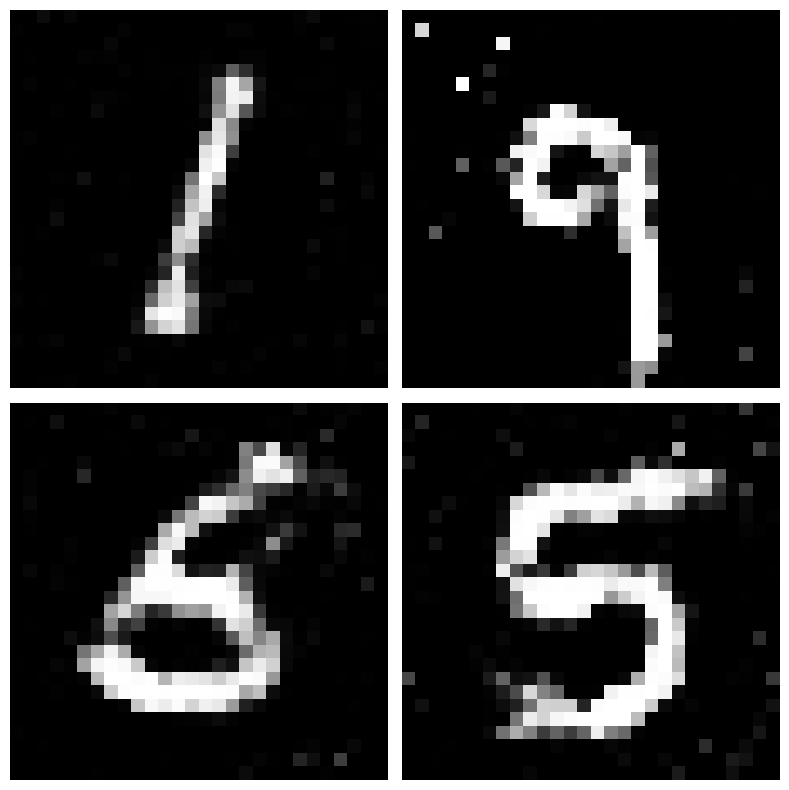

In [26]:
import numpy as np
with torch.no_grad():
# Your code here
    num_images = 4
    noise = torch.randn(num_images, n_dim, device=device)
    generated_images = generator(noise).detach().cpu()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    for i, ax in enumerate(axs.flat):
        img = generated_images[i].view(28, 28) 
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

## Question 2 - Transformers (65 points)
In this question we will be implementing a transformer architecture and apply it on a simple artificially generated dataset.

### Q2.1 Multi-Head Attention (9 points)

The attention layer works on batches of training data where each training data itself is a sequence of words/token with length at most ```seq_length``` and each word is embedded into a ```d_embedding``` dimensional vector, e.g., later when we run the transformer on the artificial dataset, the inputs to the transformer and attention layer have shapes of ```[batch_size,seq_length,d_embedding]```. Recall from the lecture that a multi-head attention layer consists of ```n_heads``` self-attention heads. The input matrices Query Q, Key K, and Value V to multi-attention head are passed through linear layers $W_Q$, $W_K$, and $W_V$ which are trainable parameters. The multi-head attention will divide the embedding vector of the input into ```n_heads``` vector of size ```d_k``` and use each as an attention head. This is particularly done by the ```make_heads``` function which transforms the input to an output of shape ```[batch_size, n_heads, seq_length, d_k]```. The multi-head attention then computes the probabilities using the input values, which is implemented by the ```compute_attention_probs``` function. It then joins them using the ```join_heads``` function and finally passes them through an output linear layer $W_O$. The **first task** is to implement the ```forward``` function of Multi-Head attention using the functions already implemented.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

class MultiHeadAttention(nn.Module):
    def __init__(self, d_embedding, n_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_embedding % n_heads == 0

        self.d_embedding = d_embedding
        self.n_heads = n_heads
        self.d_k = d_embedding // n_heads

        self.W_q = nn.Linear(d_embedding, d_embedding)
        self.W_k = nn.Linear(d_embedding, d_embedding)
        self.W_v = nn.Linear(d_embedding, d_embedding)
        self.W_o = nn.Linear(d_embedding, d_embedding)

    def compute_attention_probs(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output


    def make_heads(self, x):
        batch_size, seq_length, d_embedding = x.size()
        y=x.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)
        return x.view(batch_size, seq_length, self.n_heads, self.d_k).transpose(1, 2)

    def join_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_embedding)

    def forward(self, Q, K, V, mask=None):
       #ToDo: Complete code

        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)
    
        # Reshape and transpose for multi-head attention
        Q = self.make_heads(Q)
        K = self.make_heads(K)
        V = self.make_heads(V)

        attended_values = self.compute_attention_probs(Q, K, V, mask)
        
        # Join the heads back together
        attended_values = self.join_heads(attended_values)
    
        # Apply the final linear transformation
        output = self.W_o(attended_values)
    
        return output
        



### Q2.2 Feed-forward layer (2 points)
The output of the multi-head attention layer is used as an input to the feed-forward layer in the encoder. This layer is implemented in the following class. The **second task** is to complete the ```forward``` function of this class.

In [13]:
class FeedForward(nn.Module):
    def __init__(self, d_embedding, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_embedding, d_ff)
        self.fc2 = nn.Linear(d_ff, d_embedding)
        self.relu = nn.ReLU()

    def forward(self, x):
        #ToDO: Complete code
        return self.fc2(self.relu(self.fc1(x)))


### Q2.3 Encoder Block (9 points)

We now have all the necessary classes to build the Encoder block. The encoder block gets as input a batch of data. It first passes the input through the multi-attention layer. It then applies 1) a droput layer, 2) adds the input to the output of droupout layer as a residual, 3) applies a layer normalization, 4) and passes the output to the feed-forward layer. Finally, it applies 1) a droput layer, 2) adds the input to the output of droupout layer as a residual, and 3) Applies a layer normalization. The **third task** is to complete the ```forward``` function of this class.

In [14]:
class EncoderBlock(nn.Module):
    def __init__(self, d_embedding, n_heads, d_ff, dropout):
        super(EncoderBlock, self).__init__()
        self.self_attention = MultiHeadAttention(d_embedding, n_heads)
        self.feed_forward = FeedForward(d_embedding, d_ff)
        self.norm1 = nn.LayerNorm(d_embedding)
        self.norm2 = nn.LayerNorm(d_embedding)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        #ToDo: Complete code
        """
        Returns: The output of encoder on a given input batch x
        """
        attention_output = self.self_attention(x, x, x, mask)

        # Apply dropout to the output of the attention layer
        dropout_output = self.dropout(attention_output)
    
        # Add the input to the output of the dropout layer as a residual connection
        x = x + dropout_output
    
        # Apply layer normalization
        x = self.norm1(x)
    
        # Pass the output to the feed-forward layer
        feed_forward_output = self.feed_forward(x)
    
        # Apply dropout to the output of the feed-forward layer
        feed_forward_dropout_output = self.dropout(feed_forward_output)
    
        # Add the input to the output of the dropout layer as a residual connection
        x = x + feed_forward_dropout_output
    
        # Apply layer normalization
        x = self.norm2(x)
    
        return x

### Q2.4 Decoder Block (20 points)

In this part we will build the decoder block. The **fourth task** is to implement the DecoderBlock. You can refer to the lecture notes to find the architecture of the decoder block including the multi-attention layers, add and norm layers, and the feedforward layer. You can also add a *dropout* layer to the final add and norm layer.


In [15]:
class DecoderBlock(nn.Module):
    def __init__(self, d_embedding, n_heads, d_ff, dropout):
        super(DecoderBlock, self).__init__()
        """
        Args:
           self_attention: decoder's multi-head attention
           cross_attention: The multi-head attention layer between the encoder and the decoder
           feed_forward: feed-forward layer
           mask: mask to be given for multi head attention
           norm1: First Normalization layer
           norm2: Second Normalization layer
           norm3: Third Normalization layer
           dropout: Final dropout layer
        """
        self.self_attention = MultiHeadAttention(d_embedding, n_heads)
        self.cross_attention = MultiHeadAttention(d_embedding, n_heads)
        self.feed_forward = FeedForward(d_embedding, d_ff)
        self.norm1 = nn.LayerNorm(d_embedding)
        self.norm2 = nn.LayerNorm(d_embedding)
        self.norm3 = nn.LayerNorm(d_embedding)
        self.dropout = nn.Dropout(dropout)

        


    def forward(self, x, enc_output, src_mask, tgt_mask):
        """
        Returns: The output of decoder on a given input batch x
        """

        self_attention_output = self.self_attention(x, x, x, tgt_mask)
        
        # Apply dropout to the output of the attention layer
        self_attention_dropout_output = self.dropout(self_attention_output)

        # residual connection then layer normalization
        x = self.norm1(x + self_attention_dropout_output)

        cross_attention_output = self.cross_attention(x, enc_output, enc_output, src_mask)

        # Apply dropout to the output of the attention layer
        cross_attention_dropout_output = self.dropout(cross_attention_output)

        # residual connection then layer normalization
        x = self.norm2(x + cross_attention_dropout_output)

        feed_forward_output = self.feed_forward(x)
        feed_forward_dropout_output = self.dropout(feed_forward_output)
        x = self.norm3(x + feed_forward_dropout_output)

        return x
        
        


### Q2.5 Transformer Block (20 points)

Finally, we use the classes defined for EncoderBlock and DecoderBlock to build the TransformerBlock. The **fifth task** is to complete the ```forward``` function of this class. Note that ```num_layers``` indicates the number of encoder and decoder layers in the transformer. You can refer to the final architecture of the Transformer from the lectures. You can also include a dropout layer after embedding the source and target inputs. Remember to apply positional encoding to the input batch before passing it to the transformer.

In [19]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_embedding, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_embedding)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embedding, 2).float() * -(math.log(10000.0) / d_embedding))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_embedding, n_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_embedding)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_embedding)
        self.positional_encoding = PositionalEncoding(d_embedding, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderBlock(d_embedding, n_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderBlock(d_embedding, n_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_embedding, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    # Masking the input; the outputs returned by this function should be passed to encoder and decoder layers
    # def generate_mask(self, src, tgt):
    #     src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
    #     tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
    #     seq_length = tgt.size(1)
    #     nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
    #     tgt_mask = tgt_mask & nopeak_mask
    #     return src_mask, tgt_mask

    #modify to put mask on device
    def generate_mask(self, src, tgt):
        device = src.device  # Assuming src and tgt are already on the target device
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length, device=device), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        #ToDo: complete the code
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        """
        Returns: The output of transformer on a given input batch x
        """
        # Pass source sequence through the embedding layer, add positional encoding, and apply dropout
        src = self.encoder_embedding(src) 
        src = self.positional_encoding(src)
        src = self.dropout(src)
        
        # Pass target sequence through the embedding layer, add positional encoding, and apply dropout
        tgt = self.decoder_embedding(tgt) 
        tgt = self.positional_encoding(tgt)
        tgt = self.dropout(tgt)
        
        # Pass the embedded and encoded source sequence through the encoder stack
        for encoder in self.encoder_layers:
            src = encoder(src, src_mask)
            
        # Pass the embedded and encoded target sequence through the decoder stack, using encoder output as context
        for decoder in self.decoder_layers:
            tgt = decoder(tgt, src, src_mask, tgt_mask)
            
        # Pass the output of the last decoder layer through a linear layer to get logits for each token in the target vocabulary
        output = self.fc(tgt) 
        
        return output


### Q2.6 Training (5 points)
We can now train the model on an imaginary randomly generated dataset. The **sixth task** is to complete the training code and plot the training loss.

Epoch 1/25, Loss: 8.6891
Epoch 2/25, Loss: 8.5499
Epoch 3/25, Loss: 8.4808
Epoch 4/25, Loss: 8.4297
Epoch 5/25, Loss: 8.3774
Epoch 6/25, Loss: 8.3109
Epoch 7/25, Loss: 8.2331
Epoch 8/25, Loss: 8.1491
Epoch 9/25, Loss: 8.0719
Epoch 10/25, Loss: 7.9941
Epoch 11/25, Loss: 7.9097
Epoch 12/25, Loss: 7.8372
Epoch 13/25, Loss: 7.7415
Epoch 14/25, Loss: 7.6584
Epoch 15/25, Loss: 7.5805
Epoch 16/25, Loss: 7.4942
Epoch 17/25, Loss: 7.4193
Epoch 18/25, Loss: 7.3410
Epoch 19/25, Loss: 7.2542
Epoch 20/25, Loss: 7.1703
Epoch 21/25, Loss: 7.0931
Epoch 22/25, Loss: 7.0105
Epoch 23/25, Loss: 6.9419
Epoch 24/25, Loss: 6.8656
Epoch 25/25, Loss: 6.7927


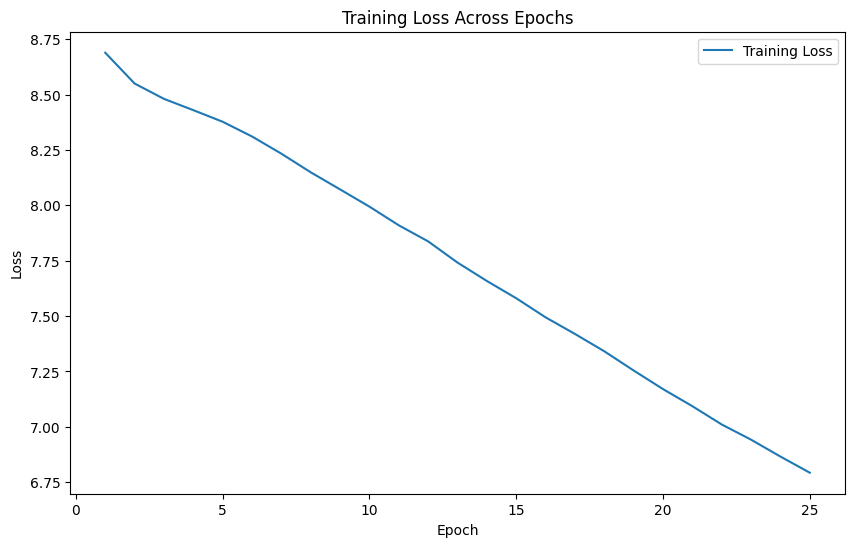

In [24]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_embedding = 512
n_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

# transformer = Transformer(src_vocab_size, tgt_vocab_size, d_embedding, n_heads, num_layers, d_ff, max_seq_length, dropout)
#put model to device
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_embedding, n_heads, num_layers, d_ff, max_seq_length, dropout).to(device)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

# for epoch in range(25):
#    #ToDo: complete the code

num_epochs = 25
batch_size = 64  

# Tracking loss for plotting
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(0, src_data.size(0), batch_size):
        # src_batch = src_data[i:i+batch_size]
        # tgt_batch = tgt_data[i:i+batch_size]
        
        #put data to device
        src_batch = src_data[i:i+batch_size].to(device)
        tgt_batch = tgt_data[i:i+batch_size].to(device)
        
        # Shift the targets for tgt_input & tgt_output
        tgt_input = tgt_batch[:, :-1]
        tgt_output = tgt_batch[:, 1:]
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass through the model
        output = transformer(src_batch, tgt_input)
        
        # Reshape output and targets to fit the loss function
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        tgt_output = tgt_output.contiguous().view(-1)
        
        # Compute loss
        loss = criterion(output, tgt_output)
        epoch_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        
        # Update model parameters
        optimizer.step()
    
    epoch_loss /= (src_data.size(0) // batch_size)
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Plotting training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Across Epochs')
plt.legend()
plt.show()
